# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib widget
plt.rc('text', usetex = True)
plt.rcParams['figure.facecolor'] = 'w'
plt.style.use('classic')

In [2]:
path = f"/Users/max/SLAC Fall 2024/LXeSims/window_test"

cols = 'x y z Px Py Pz t PDGid EventID TrackID ParentID Weight Edep VisibleEdep Ntracks'.split(' ')

n_events = 1e5

# Electron charge in C
e_charge = 1.602176634e-19

n_incident = 2.5e10
n_bunches = 1312

ILC_scale = n_bunches * n_incident / n_events

# Load data

In [4]:
start=0.0125
stop=3.0
step=0.0125

radius = 1.0 # cm
density = 1.848 # g/cm^3

thicknesses = np.arange(start, stop+step, step) # mm

data = np.zeros(len(thicknesses), dtype=object)
mass = np.zeros(len(thicknesses))

for idx,val in enumerate(thicknesses):
    data[idx] = pd.read_csv(path+f"/Win.{idx+1}.txt", skiprows=1, header=0, delim_whitespace=True, names=cols)
    mass[idx] = np.pi * radius**2 * val/10 * density # g

# Extract $E_{\mathrm{dep}}$ and $E_{\mathrm{dep}}$ Density for each window

In [5]:
n = 100 # n by n grid

Edep_data = np.zeros(len(thicknesses), dtype=object)
EDD_data = np.zeros(len(thicknesses), dtype=object)

reference_bin_mass = np.zeros(len(thicknesses))

# Bin the Edep data (scaled to ILC parameters)
for idx,val in enumerate(thicknesses):
    bin_vol = (2*radius/n)**2 * val/10 # cm^3
    bin_mass = bin_vol * density # g
    
    # store bin_mass for later use
    reference_bin_mass[idx] = bin_mass # g
    
    h = np.histogram2d(
        x=data[idx]['x']/10,
        y=data[idx]['y']/10,
        weights=data[idx]['Edep'] * 1e6 * e_charge, # J
        bins=n,
    )

    Edep_data[idx] = data[idx]['Edep'] / (1e6 * e_charge) # MeV

    x_edges = h[1]
    y_edges = h[2]

    x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_bin_centers = (y_edges[:-1] + y_edges[1:]) / 2

    Edep_per_bin = h[0]

    # Extract Edep, divide by mass of bin, scale to ILC parameters
    EDD = Edep_per_bin / bin_mass * ILC_scale # J/g

    EDD_data[idx] = [ x_edges, y_edges, EDD.T, x_bin_centers, y_bin_centers ]

# Analyze window $E_{\mathrm{dep}}$ and $\mathrm{EDD}$

## $\mathrm{EDD}$

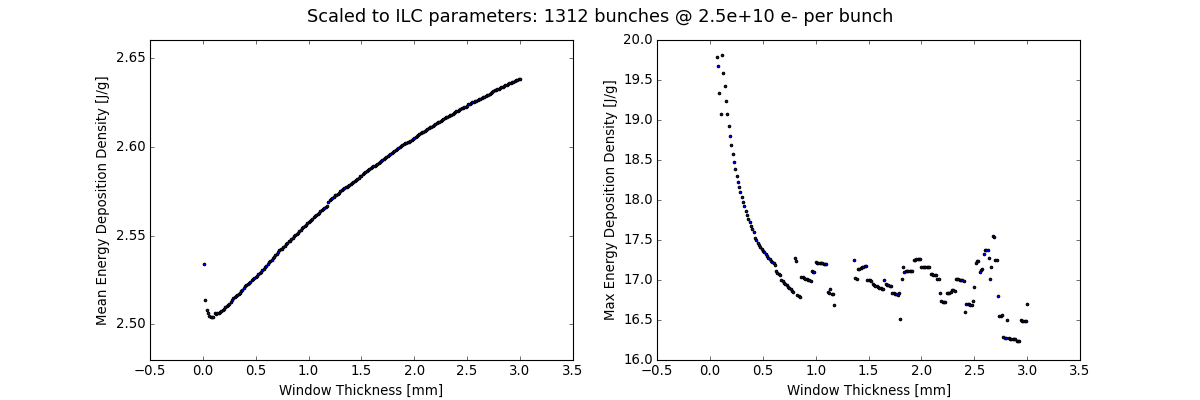

In [16]:
# Only look at bins within 0.1 mm of the window radius (basically ignore bins that are not actually part of the window)
win_mask = [ np.sqrt(EDD_data[i][4]**2 + EDD_data[i][3]**2) <= radius + 1e-2 for i in range(len(thicknesses)) ]
mean_edd = [ EDD_data[i][2][win_mask[i]].mean() for i in range(len(thicknesses)) ] # J/g
max_edd = [ EDD_data[i][2][win_mask[i]].max() for i in range(len(thicknesses)) ] # J/g

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle(f'Scaled to ILC parameters: {n_bunches} bunches @ {n_incident:.1e} e- per bunch\n', fontsize=16)

ax[0].scatter(thicknesses, mean_edd, marker='.')
ax[0].set_xlabel('Window Thickness [mm]')
ax[0].set_ylabel('Mean Energy Deposition Density [J/g]')

ax[1].scatter(thicknesses, max_edd, marker='.')
ax[1].set_ylim(16,20)
ax[1].set_xlabel('Window Thickness [mm]')
ax[1].set_ylabel('Max Energy Deposition Density [J/g]')

plt.show()

## $E_{\mathrm{dep}}$

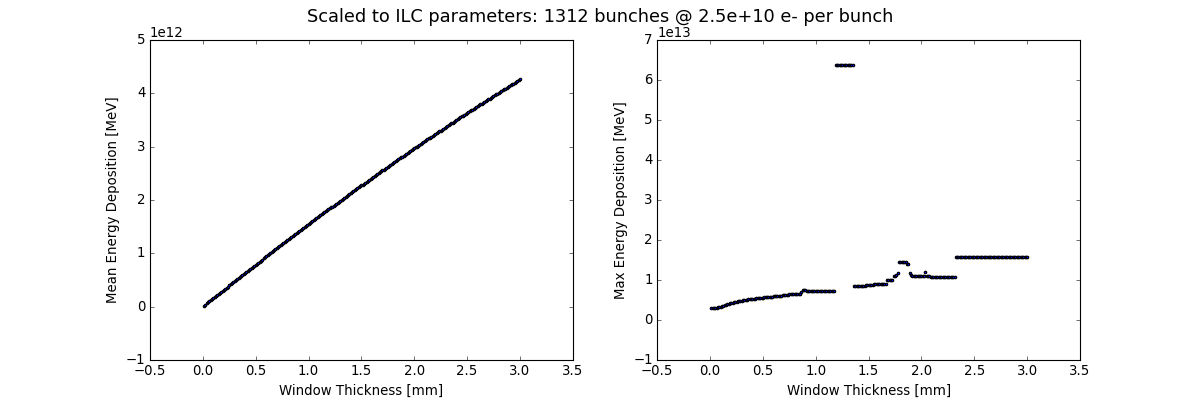

In [13]:
mean_edep = [ Edep_data[i].mean() for i in range(len(thicknesses)) ] # MeV
max_edep = [ Edep_data[i].max() for i in range(len(thicknesses)) ] # MeV

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle(f'Scaled to ILC parameters: {n_bunches} bunches @ {n_incident:.1e} e- per bunch\n', fontsize=16)

ax[0].scatter(thicknesses, mean_edep, marker='.')
ax[0].set_xlabel('Window Thickness [mm]')
ax[0].set_ylabel('Mean Energy Deposition [MeV]')

ax[1].scatter(thicknesses, max_edep, marker='.')
ax[1].set_xlabel('Window Thickness [mm]')
ax[1].set_ylabel('Max Energy Deposition [MeV]')

plt.show()

# Check beam $\sigma_{x,y}$ upon entrance

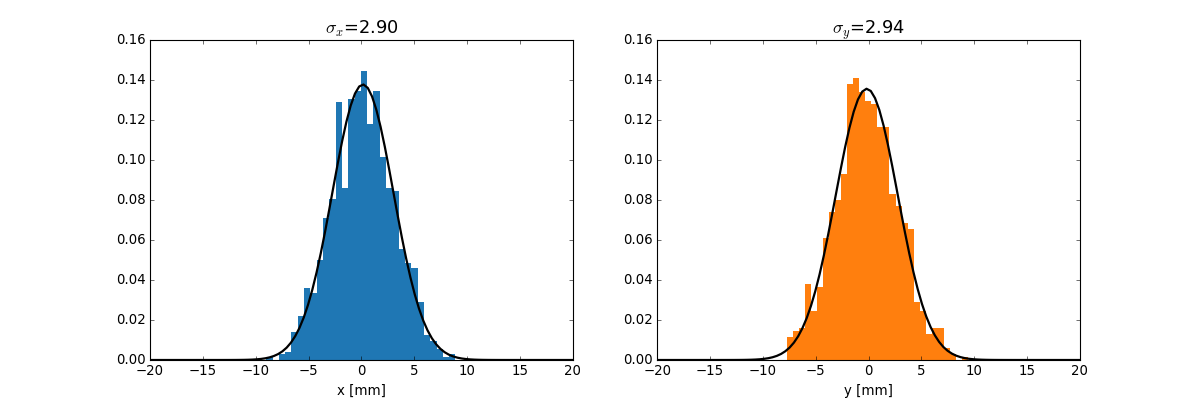

In [17]:
from scipy.stats import norm

# df = pd.read_csv(path+'/EntranceWinDet.txt', skiprows=3, names='x y z Px Py Pz t PDGid EventID TrackID ParentID Weight'.split(' '), delim_whitespace=True).drop(index=0)

# df = df[(df['PDGid'] == 11) & (np.sqrt(df['x']**2 + df['y']**2) < 20)]

df = data[0]

fitX = np.linspace(-20, 20, 100)

muX, stdX = norm.fit(df['x'])
muY, stdY = norm.fit(df['y'])

pX = norm.pdf(fitX, muX, stdX)
pY = norm.pdf(fitX, muY, stdY)

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
h = ax[0].hist(df['x'], facecolor = 'tab:blue', bins = 30, linewidth = 0, density=True)
ax[0].plot(fitX, pX, 'k', linewidth=2)
ax[0].set_xlabel('x [mm]')
ax[0].set_title(r'$\sigma_x$=' + f'{stdX:.2f}', fontsize=16)

h = ax[1].hist(df['y'], facecolor = 'tab:orange', bins = 30, linewidth = 0, density=True)
ax[1].plot(fitX, pY, 'k', linewidth=2)
ax[1].set_xlabel('y [mm]')
ax[1].set_title(r'$\sigma_y$=' + f'{stdY:.2f}', fontsize=16)

plt.show()

# Test plot of mass vs thickness

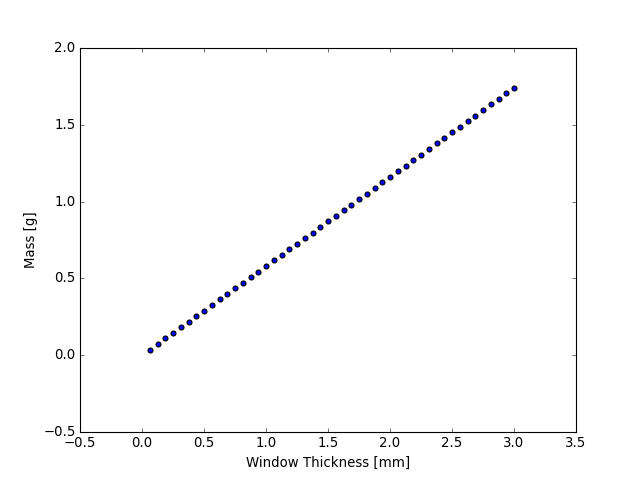

In [15]:
plt.close()
plt.figure()
plt.scatter(thicknesses, mass)
plt.xlabel('Window Thickness [mm]')
plt.ylabel('Mass [g]')
plt.show()